In [ ]:
"""
upload doc to ai
explain legal document in simple terms
memory
answer questions based on the document

Different functions tools
doc reading
question answering(advice giving)
doc writing
memory reading
memory writing
summarise
web search

the program will greet the user as an Ai lawyer
The user will tell the user what he or she wants
if the user uploads a document the program should extract the information from the doc
the ai should perform whatever instructions were asked on the document

So basically
the bot should answer questions on legal matters and give legal advice
the bot should be able to draft legal documents for the user
the bot should be able to store information of users in an sqlite database
the bot must summarise all the messages from users after a certain lenght
the bot must be able to extract insights from the document

functions

"""

'\nupload doc to ai\nexplain legal document in simple terms\nmemory\nanswer questions based on the document\n\nDifferent functions tools\ndoc reading\nquestion answering(advice giving)\ndoc writing\nmemory reading\nmemory writing\nsummarise\nweb search\n\nthe program will greet the user as an Ai lawyer\nThe user will tell the user what he or she wants\nif the user uploads a document the program should extract the information from the doc\nthe ai should perform whatever instructions were asked on the document\n\nSo basically\nthe bot should answer questions on legal matters and give legal advice\nthe bot should be able to draft legal documents for the user\nthe bot should be able to store information of users in an sqlite database\nthe bot must summarise all the messages from users after a certain lenght\nthe bot must be able to extract insights from the document\n\nfunctions\n\n'

In [ ]:
!pip install langchain_openai langchain_community langgraph pypdf chromadb
!pip install langgraph-checkpoint-sqlite

In [ ]:
from google.colab import userdata
open_api = userdata.get("OPENAI_API_KEY")

In [ ]:
"""
create a chroma db vector store out of the constituion and a function to search it
"""
import os
from langchain.document_loaders import TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain_community.document_loaders import PyPDFLoader

current_dir = os.path.abspath(r"/content/")
book_dir = current_dir
persistent_directory = os.path.abspath(r"/content/db")
print(f"book dir: {book_dir}")
print(f"Persistent directory: {current_dir}")

if not os.path.exists(persistent_directory):
    print("Persistent directory does not exist. Initializing vector store...")

    if not os.path.exists(book_dir):
        raise FileNotFoundError(f"The directory {book_dir} does not exist. Please check the path.")

    book_files = [f for f in os.listdir(book_dir) if f.endswith(".pdf")]

    documents = []
    for book_file in book_files:
      file_path = os.path.join(book_dir, book_file)
      loader = PyPDFLoader(file_path)
      book_docs = loader.load()
      for doc in book_docs:
        doc.metadata["source"] = book_file
        documents.append(doc)
#loader = TextLoader(book_dir)
      # loader = PyPDFLoader(file_path)
      # documents = loader.load()
      text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
      texts = text_splitter.split_documents(documents)

      print("\n--- Document Chunks Information ---")
      print(f"Number of documents chunks: {len(texts)}")
      print("\n--- Creating embeddings ---")
      embeddings = OpenAIEmbeddings(model="text-embedding-3-small",api_key=open_api)
      print("\n--- Finished creating embeddings ---")

      print("\n--- Creating and persisting vector store ---")
      db = Chroma.from_documents(documents=texts, embedding=embeddings, persist_directory=persistent_directory)
      print("\n--- Finished creating and persisting vector store ---")

else:
  print("Vector store already exists. No need to initialize.")



book dir: /content
Persistent directory: /content
Persistent directory does not exist. Initializing vector store...

--- Document Chunks Information ---
Number of documents chunks: 215

--- Creating embeddings ---


/tmp/ipython-input-6-1047364247.py:42: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embeddings = OpenAIEmbeddings(model="text-embedding-3-small",api_key=open_api)



--- Finished creating embeddings ---

--- Creating and persisting vector store ---

--- Finished creating and persisting vector store ---


In [ ]:
def reading_vector(query):
  embeddings = OpenAIEmbeddings(model="text-embedding-3-small", api_key=open_api)
  db = Chroma(
      persist_directory=persistent_directory,
      embedding_function=embeddings,
  )
  retriever = db.as_retriever(
      search_type = "similarity_score_threshold",
      search_kwargs = {"k":3, "score_threshold":0.1}
  )
  relevant_docs = retriever.invoke(query)
  print(f"\n--- Relevant Documents ---")
  for i, doc in enumerate(relevant_docs, 1):
    print(f"Document {i}: {doc.page_content}\n")
    if doc.metadata:
      print(f"Source: {doc.metadata.get('source', 'Unknown')}\n")

In [ ]:
reading_vector("police")


--- Relevant Documents ---
Document 1: CHAPTER FIFTEEN 
THE POLICE SERVICE 
200. The Police Service 
201. The Police Council 
202. The Inspector-General of Police and Appointment of Members of Police service 
203. Functions of the Police Council 
204. Regional Police Committees 
CHAPTER SIXTEEN 
THE PRISONS SERVICE 
205. The Prisons Service 
206. The Prisons Service Council 
207. Director-General of Prisons Service and Appointment of Members of Service 
208. Functions of Prisons Service Council 
209. Regional Prisons Committees 
CHAPTER SEVENTEEN 
THE ARMED FORCES OF GHANA 
210. Armed Forces of Ghana 
211. Armed Forces Council 
212. Appointments 
213. The Chief of Defence Staff 
214. Functions of Armed Forces Council 
215. Delegation of Functions

Source: constitution.pdf

Document 2: (4) The President may, subject to such conditions as he thinks fit, 
delegate some of his functions under this article by directions in writing 
to the Police Council or to a committee or to a member of 

In [ ]:
import os
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain.pydantic_v1 import BaseModel, Field
from langchain.tools import BaseTool


def ask_const(query):
  """ Retrieve docs from the vector search"""
  current_dir = os.path.abspath(r"/content/")
  persistent_directory = os.path.abspath(r"/content/db")
  embeddings = OpenAIEmbeddings(model="text-embeddings-3-small",api_key=open_api)

  db = Chroma(
      persist_directory=persistent_directory,
      embedding_function=embeddings,
  )

  retriever = db.as_retriever(
      search_type="similarity_score_threshold",
      search_kwargs={"k":5,"score_threshold": 0.1},
  )
  relevant_docs = retriever.invoke(query)
  # print(f"\n--- Relevant Documents ---")
  # for i, doc in enumerate(relevant_docs, 1):
  #   print(f"Document {i}:\n{doc.page_content}\n")
  #   if doc.metadata:
  #     print(f"Source: {doc.metadata.get('source','Unknown')}\n")
  return relevant_docs

class SimpleSearch(BaseModel):
  query: str = Field(description="Search query")
  gen_query: str = Field(description="Generated query")
  output: str = Field(description="Output from vector database")

# class SimpleSearchTool(BaseTool):
#   name: str = "simple_search"
#   description: str = "useful for when you need to answer questions about legal matters"
#   args_schema: Type[BaseModel] = SimpleSearch

#   def _run(self, query: str) -> str:
#     results = ask_const(query)
#     return f"Search results for: {query}\n\n\n{results}\n"

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


Experts

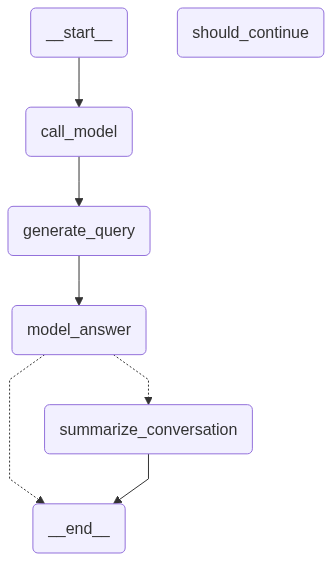

/usr/local/lib/python3.11/dist-packages/langchain_openai/chat_models/base.py:1759: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/langchain_core/vectorstores/base.py:1082: UserWarning: Relevance scores must be between 0 and 1, got [(Document(metadata={'producer': 'Microsoft® Word 2019', 'creationdate': '2020-10-15T05:26:13+00:00', 'moddate': '2020-10-15T05:26:13+00:00', 'page': 17, 'creator': 'Microsoft® Word 2019', 'total_pages': 215, 'source': 'constitution.pdf', 'page_label': '18', 'author': 'DELL'}, page_content='CHAPTER EIGHTEEN \nCOMMISSION ON HUMAN RIGHTS AND ADMINISTRATIVE JUSTICE \n216. Commission on Human Rights and Administrative Justice \n217. Appointment of Members of Commission \n218. Functions of Commission \n219. Special Powe

{'messages': [HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='0e2639b8-7ff8-4bb9-9a51-219dedee21ce'),
  AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-Bk9sn17DGOcCi8JBQcSLPYL0kkYX6', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--133052ff-a47e-40c7-8936-7c50e3de46ec-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})],
 'query': 'Hello',
 'gen_query': 'Hello

In [ ]:
def generate_query(state: State):
  """ Node to generate a query """
  # Use the content attribute of the search_instructions SystemMessage
  prompt_text = search_instructions.content.format(query=state["query"])
  # Pass the prompt text to the model
  response = model.with_structured_output(Status).invoke(prompt_text)
  # Correct the key to 'gen_query' to match the state definition
  return {"gen_query": response.gen_query}

def model_answer(state: State):
  """ Node to generate answer for user """
  # Access gen_query using the corrected key
  state["output"] = ask_const(state["gen_query"])
  # Format the answer_instructions content directly
  prompt_text = answer_instructions.content.format(search=state["output"], query=state["query"])
  # Invoke the model with the formatted prompt text.
  # The with_structured_output already expects a message or a string prompt.
  response = model.with_structured_output(Status).invoke(prompt_text)
  # Update the state with the output.
  # The response from the structured output call will be an instance of the Status model.
  # Access the 'output' field from this Status instance.
  return {"output": response.output}

# Rest of your code remains the same
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
from re import search
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langgraph.graph import END, START, StateGraph
from langgraph.graph import MessagesState
from langchain.pydantic_v1 import BaseModel, Field # Import BaseModel and Field
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
import os

# Define the Status class here
class Status(BaseModel):
  gen_query: str = Field(description="Generated search query based on user input")
  output: str = Field(description="Output from the model answer") # Add output field to Status

class State(MessagesState):
  summary: str
  query: str
  gen_query: str
  search: str
  output: str

# Define ask_const function (copy from original notebook)
def ask_const(query):
  """ Retrieve docs from the vector search"""
  current_dir = os.path.abspath(r"/content/")
  persistent_directory = os.path.abspath(r"/content/db")
  embeddings = OpenAIEmbeddings(model="text-embedding-3-small", api_key=open_api) # Corrected model name

  db = Chroma(
      persist_directory=persistent_directory,
      embedding_function=embeddings,
  )

  retriever = db.as_retriever(
      search_type="similarity_score_threshold",
      search_kwargs={"k":5,"score_threshold": 0.1},
  )
  relevant_docs = retriever.invoke(query)
  return relevant_docs

def call_model(state: State):
  summary = state.get("summary","")

  if summary:
    system_message = f"Summary of conversation earlier: {summary}"
    # Ensure messages is a list of Message objects
    messages = [SystemMessage(content=system_message)] + state["messages"]

  else:
    messages = state["messages"]

  response = model.invoke(messages)
  return {"messages": response}

def summarize_conversation(state: State):
  summary = state.get("summary","")

  if summary:
    summary_message_content = (
        f"This is summary of the conversation to date: {summary}\n\n"
        "Extend the summary by taking into account the new messages above:"
    )
  else:
    summary_message_content = "Create a summary of the conversation above:"
    messages = state["messages"] + [HumanMessage(content=summary_message_content)]
    response = model.invoke(messages)

    # Remove the last two messages before returning, which are the original message and the summary prompt
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]] if len(state["messages"]) >= 2 else []
    return {"summary": response.content, "messages": delete_messages}


def should_continue(state: State):
  messages = state["messages"]
  if len(messages) > 6: # Check if the total number of messages exceeds 6
    return "summarize_conversation"

  return END

# Define system messages (copy from original notebook)
search_instructions = SystemMessage(content="""You will be given a conversation between a lawyer and a client.

Your goal is to generate a well-structured query for use in retrieval from a vector store
First, analyze the full conversation: {query}.

Pay particular attention to the final question posed by the client.

Convert this final question into a well-structured vector store query""")

answer_instructions = SystemMessage(content="""You are a lawyer in Ghana and this is the request of your client is: {query}.

Here is the some search results from the Constitution of Ghana which should be your area of focus: {search}.

Your goals are to answer a questions posed by the client, understand legal documents and explain to the user, generate legal documents for the user as specifically as possible.

When answering questions, follow these guidelines:

1. Use only the information provided in the context.

2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

""")
# Re-instantiate the model after defining Status
model = ChatOpenAI(model="gpt-4o", temperature=0, api_key=open_api)


builder = StateGraph(State)
builder.add_node("call_model", call_model)
builder.add_node("generate_query", generate_query)
builder.add_node("model_answer", model_answer)
builder.add_node("summarize_conversation", summarize_conversation)
builder.add_node("should_continue", should_continue)
builder.add_edge(START,"call_model")
builder.add_edge("call_model", "generate_query")
builder.add_edge("generate_query", "model_answer")
builder.add_conditional_edges("model_answer", should_continue, ["summarize_conversation", END])



memory = MemorySaver()
graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

config = {"configurable": {"thread_id":"1"}}

messages = [HumanMessage(content="Hello")]

# Add the initial query to the state
initial_state = {"messages": messages, "query": messages[0].content}

graph.invoke(initial_state, config)

In [ ]:
config = {"configurable": {"thread_id":"1"}}

messages = [HumanMessage(content="Hello, generate a letter of intent for me to send to a owner of a company I intend to buy")]

messages = graph.invoke({"messages": messages}, config)

for m in messages["messages"]:
  m.pretty_print()

/usr/local/lib/python3.11/dist-packages/langchain_openai/chat_models/base.py:1759: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/langchain_core/vectorstores/base.py:1082: UserWarning: Relevance scores must be between 0 and 1, got [(Document(metadata={'page_label': '16', 'creator': 'Microsoft® Word 2019', 'moddate': '2020-10-15T05:26:13+00:00', 'page': 15, 'creationdate': '2020-10-15T05:26:13+00:00', 'source': 'constitution.pdf', 'total_pages': 215, 'producer': 'Microsoft® Word 2019', 'author': 'DELL'}, page_content='183. The Central Bank \n184. Foreign Exchange Dealings \nStatistical Service \n185. Statistical Service \n186. Statistical Service Board \nThe Auditor-General \n187. The Auditor-General \nThe Audit Service \n188. The Audit Servi

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I assist you today?
================================ Human Message =================================

Hello, generate a letter of intent for me to send to a owner of a company I intend to buy
================================== Ai Message ==================================

Certainly! Below is a template for a letter of intent to purchase a company. You can customize it to fit your specific situation and details.

---

[Your Name]  
[Your Address]  
[City, State, ZIP Code]  
[Email Address]  
[Phone Number]  
[Date]  

[Owner's Name]  
[Company Name]  
[Company Address]  
[City, State, ZIP Code]  

Dear [Owner's Name],

I am writing to express my interest in acquiring [Company Name]. After conducting preliminary research and analysis, I am impressed with the company's operations, market position, and grow